In [ ]:
import pandas as pd
import numpy as np
import calendar
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_csv("outbreaks.csv", low_memory=False)
print("Raw shape:", df.shape)


Raw shape: (19119, 12)


In [ ]:
df = df.dropna(subset=["Year","Month","Illnesses"])
print("After dropping missing core fields:", df.shape)


After dropping missing core fields: (19119, 12)


In [ ]:
# Map Month name = number
month_map = {m: i for i,m in enumerate(calendar.month_name) if m}
df["Month_Num"] = df["Month"].map(month_map)

# Create 1st-of-month Date
df["Date"] = pd.to_datetime(dict(
    year  = df["Year"].astype(int),
    month = df["Month_Num"].astype(int),
    day   = 1
))


In [ ]:
# Group by the fields you care about numerically
# (we keep Year, Month, State, Location, Illnesses, Hospitalizations, Fatalities, Date)
key_cols = ["Year","Month","State","Location","Illnesses","Hospitalizations","Fatalities","Month_Num","Date"]

cleaned = (
    df
    .groupby(key_cols, as_index=False)
    .agg({
        "Food":              lambda x: ";".join(sorted(set(x.dropna()))),
        "Ingredient":        lambda x: ";".join(sorted(set(x.dropna()))),
        "Species":           lambda x: ";".join(sorted(set(x.dropna()))),
        "Serotype/Genotype": lambda x: ";".join(sorted(set(x.dropna()))),
        "Status":            lambda x: ";".join(sorted(set(x.dropna())))
    })
)

print("After collapsing descriptor-duplicates:", cleaned.shape)

# Save out your cleaned file
cleaned.to_csv("outbreaks_clean.csv", index=False)


After collapsing descriptor-duplicates: (12520, 14)


Year                 0
Month                0
State                0
Location             0
Illnesses            0
Hospitalizations     0
Fatalities           0
Month_Num            0
Date                 0
Food                 0
Ingredient           0
Species              0
Serotype/Genotype    0
Status               0
dtype: int64


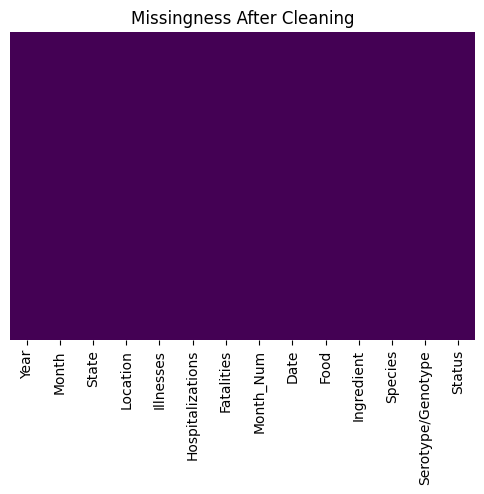

In [ ]:
print(cleaned.isna().sum())

plt.figure(figsize=(6,4))
sns.heatmap(cleaned.isna(), cbar=False, yticklabels=False, cmap="viridis")
plt.title("Missingness After Cleaning")
plt.show()


count    12520.000000
mean        19.927316
std         44.462598
min          2.000000
25%          4.000000
50%          9.000000
75%         20.000000
max       1644.000000
Name: Illnesses, dtype: float64


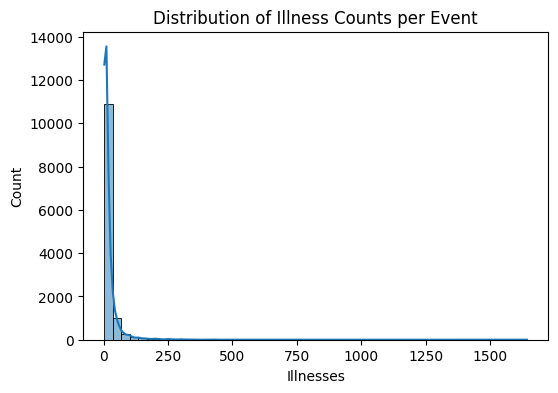

In [ ]:
print(cleaned["Illnesses"].describe())

plt.figure(figsize=(6,4))
sns.histplot(cleaned["Illnesses"], bins=50, kde=True)
plt.title("Distribution of Illness Counts per Event")
plt.show()


In [ ]:
for col in ["State","Location","Food","Species","Status"]:
    print(f"\nTop 5 {col}:")
    print(cleaned[col].value_counts().head())



Top 5 State:
State
California    1618
Illinois       905
Ohio           885
Florida        846
Minnesota      772
Name: count, dtype: int64

Top 5 Location:
Location
Restaurant                7156
Private Home/Residence    1382
Catering Service           871
Fast Food Restaurant       357
Banquet Facility           338
Name: count, dtype: int64

Top 5 Food:
Food
                       6066
Multiple Foods          101
Oysters, Raw            100
Salad, Unspecified       81
Sandwich, Submarine      58
Name: count, dtype: int64

Top 5 Species:
Species
                          3553
Norovirus genogroup I     1917
Salmonella enterica       1642
Norovirus genogroup II    1194
Norovirus unknown          634
Name: count, dtype: int64

Top 5 Status:
Status
Confirmed               5802
                        3553
Suspected               2690
Suspected; Suspected     201
Confirmed; Confirmed      97
Name: count, dtype: int64


In [ ]:
monthly = (
    cleaned
    .groupby("Date")["Illnesses"]
    .sum()
    .asfreq("MS")
    .fillna(0)
)


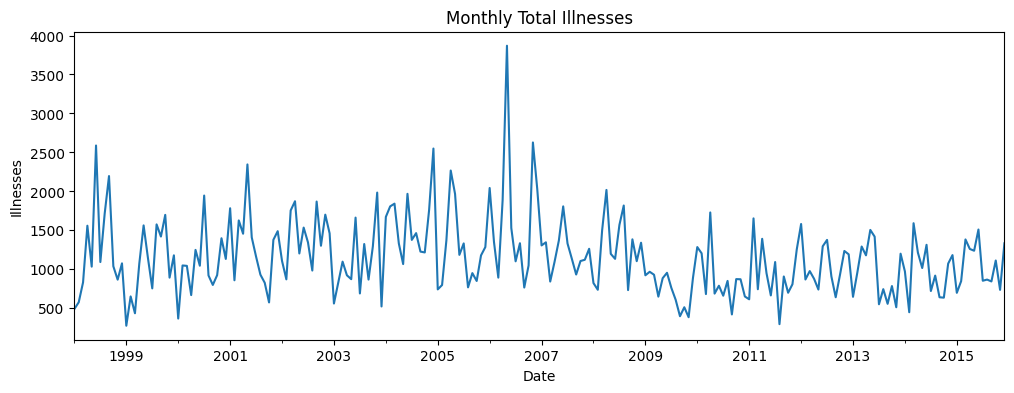

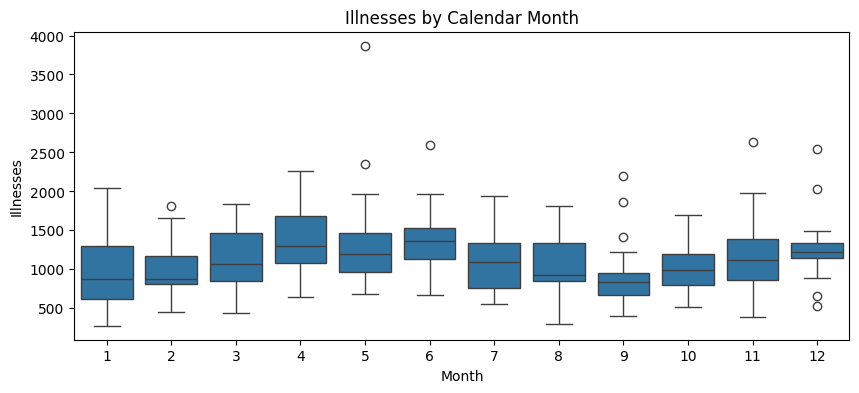

In [ ]:
plt.figure(figsize=(12,4))
monthly.plot()
plt.title("Monthly Total Illnesses")
plt.ylabel("Illnesses")
plt.show()

mdf = monthly.reset_index().assign(Month=lambda d: d.Date.dt.month)
plt.figure(figsize=(10,4))
sns.boxplot(x="Month", y="Illnesses", data=mdf)
plt.title("Illnesses by Calendar Month")
plt.show()


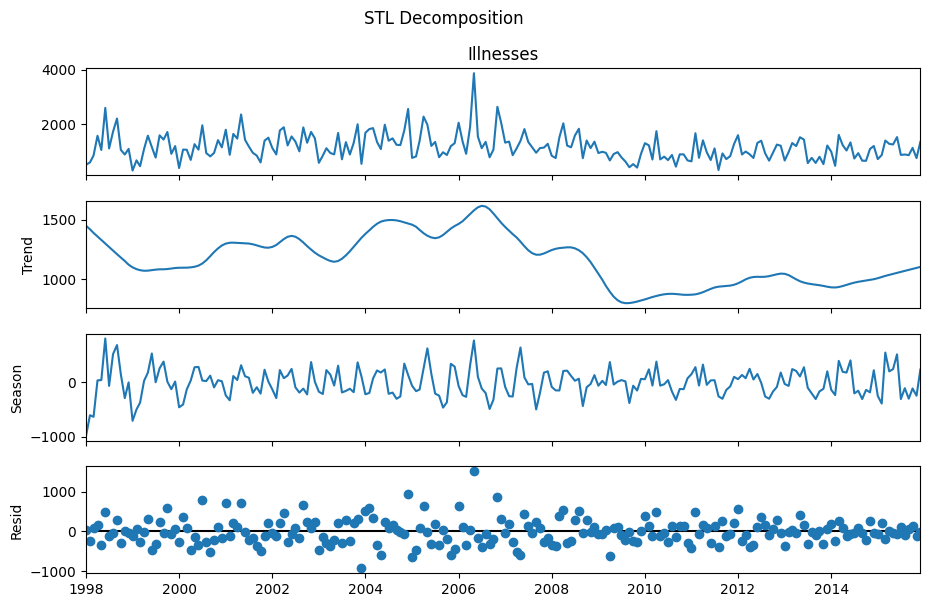

In [ ]:
from statsmodels.tsa.seasonal import STL

stl = STL(monthly, period=12)
res = stl.fit()
fig = res.plot()
fig.set_size_inches(10,6)
plt.suptitle("STL Decomposition", y=1.02)
plt.show()


In [ ]:
from statsmodels.tsa.stattools import adfuller

stat, pval, _, _, crit, _ = adfuller(monthly)
print(f"ADF p-value = {pval:.4f}  →",
      "stationary " if pval<0.05 else "non-stationary ")
print("Critical values:", crit)


ADF p-value = 0.0000  → stationary ✅
Critical values: {'1%': np.float64(-3.461136478222043), '5%': np.float64(-2.875078880098608), '10%': np.float64(-2.5739861168199027)}


In [ ]:
cleaned['Hospitalizations'] = cleaned['Hospitalizations'].astype(int)
cleaned['Fatalities']       = cleaned['Fatalities'].astype(int)


In [ ]:
q1, q3 = cleaned['Illnesses'].quantile([0.25,0.75])
iqr = q3 - q1
outliers = cleaned.loc[cleaned['Illnesses'] > q3 + 3*iqr]
print("Suspiciously large events:\n", outliers[['Date','Illnesses']])


Suspiciously large events:
             Date  Illnesses
4     1998-04-01         72
22    1998-04-01         71
39    1998-04-01        800
63    1998-08-01         81
64    1998-08-01        644
...          ...        ...
12425 2015-10-01        188
12445 2015-10-01        170
12468 2015-10-01        121
12474 2015-09-01        252
12517 2015-09-01        160

[597 rows x 2 columns]


In [ ]:
print("Date span:", cleaned['Date'].min(), "→", cleaned['Date'].max())


Date span: 1998-01-01 00:00:00 → 2015-12-01 00:00:00


In [ ]:
cleaned.to_parquet("outbreaks_clean.parquet", index=False)


In [ ]:
cleaned.to_csv("outbreaks_clean.csv", index=False)

# Save your monthly-aggregated series too:
monthly.to_frame("Total_Illnesses") \
       .to_csv("monthly_illnesses.csv")


In [ ]:
cleaned.to_parquet("outbreaks_clean.parquet", index=False)
